# Trabajo Práctico 2

# Imports y función de entrenamiento

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, zero_one_loss, accuracy_score
from sklearn.model_selection import train_test_split
import copy
import math
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
#función que entrena una red ya definida previamente "evaluaciones" veces, cada vez entrenando un número de épocas elegido al crear la red y midiendo el error en train, validación y test al terminar ese paso de entrenamiento.
#Guarda y devuelve la red en el paso de evaluación que da el mínimo error de validación
#entradas: la red, las veces que evalua, los datos de entrenamiento y sus respuestas, de validacion y sus respuestas, de test y sus respuestas
#salidas: la red entrenada en el mínimo de validación, los errores de train, validación y test medidos en cada evaluación
def entrenar_red(red, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test):
    if type(red) == MLPRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss

    best_red = red
    best_red_error = 1.0
    error_train = []
    error_val = []
    error_test = []

    for i in range(evaluaciones):
      red.fit(X_train, y_train)

      P_train = red.predict(X_train)
      error_train.append(error_fun(y_train, P_train))

      P_val = red.predict(X_val)
      red_error_val = error_fun(y_val, P_val)
      error_val.append(red_error_val)

      P_test = red.predict(X_test)
      error_test.append(error_fun(y_test, P_test))

      if red_error_val < best_red_error:
        best_red = copy.deepcopy(red)
        best_red_error = red_error_val

    return best_red, error_train, error_val, error_test

In [3]:
def entrenar_red_weight_decay(red, evaluaciones, X_train, y_train, X_test, y_test, weight_fun = np.square):
    if type(red) == MLPRegressor:
      error_fun = mean_squared_error
    else:
      error_fun = zero_one_loss

    error_train = []
    error_test = []
    weight_sum = []

    for i in range(evaluaciones):
      red.fit(X_train, y_train)

      P_train = red.predict(X_train)
      error_train.append(error_fun(y_train, P_train))

      P_test = red.predict(X_test)
      error_test.append(error_fun(y_test, P_test))

      weight_sum.append(np.sum([np.sum(weight_fun(w)) for w in red.coefs_]))

    return red, error_train, error_test, weight_sum

In [4]:
def cargar_csv(path, xcols=2, delim_whitespace=False):
    """
    Argumentos:
      path (str): ruta al archivo csv a cargar
      xcols (int): cantidad de columnas que representan las entradas,
        la columna restante representara la clase o dato de salida
    """
    df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
    X = df.loc[:, 0:(xcols-1)]
    y = df.loc[:, xcols]
    return X,y

# Ejercicio 1

## Espirales

Generar n datos. De los n puntos generados, n/2 deben pertenecer a cada clase.

Los datos tienen 2 inputs, x e y, que corresponden a puntos generados al azar con una distribución UNIFORME (en dicho sistema de referencia x-y) dentro de un circulo de radio 1.

El output es binario, correspondiendo la clase 0 a los puntos que se encuentran entre las curvas ro = theta/4pi y ro = (theta + pi)/4pi (en polares) y la clase 1 al resto.

In [36]:
def cartesian_to_polar(x, y):
    rho = (x**2 + y**2)**0.5
    theta = math.atan2(y, x)
    return rho, theta

def is_inside_curve(rho, theta, npi):
  rho_curve1 = (theta + (npi-1)*math.pi) / (4 * math.pi)
  rho_curve2 = (theta + npi*math.pi) / (4 * math.pi)
  return rho_curve1 <= rho <= rho_curve2

def is_inside_curves(x, y):
    rho, theta = cartesian_to_polar(x, y)
    return is_inside_curve(rho, theta, 1) or is_inside_curve(rho, theta, 3) or is_inside_curve(rho, theta, 5)

def espirales(n):
  count0 = 0
  count1 = 0
  l = []
  while (count0 + count1) < n:
    x = np.random.uniform(-1, 1, 1)
    y = np.random.uniform(-1, 1, 1)
    if ((x**2 + y**2)**0.5 < 1): # si esta adentro del circulo
      if (is_inside_curves(x, y)):
        if count0 < int(n/2):
          l.append([x, y, 0])
          count0+=1
      else:
        if count1 < int(n/2):
          l.append([x, y, 1])
          count1+=1
  df = pd.DataFrame(l, columns=['dim_1', 'dim_2', 'class'])
  return df

## Entrenamiento Redes

In [37]:
redes = {}

#defino parámetros de la red
epocas_por_entrenamiento=20     #numero de epocas que entrena cada vez
eta=0.1                         #learning rate
alfa=0.9                        #momentum
evaluaciones = 1000

In [5]:
df_train = espirales(600)
train_target = df_train["class"].to_numpy()
train_data = df_train.drop(columns=["class"]).to_numpy()
X_train, X_val, y_train, y_val = train_test_split(train_data, train_target, test_size = 0.2)

df_test = espirales(2000)
feature_names = list(df_test.columns.values)[:-1]
y_test = df_test["class"].to_numpy()
X_test = df_test.drop(columns=["class"]).to_numpy()

### Red 2 hidden

In [15]:
N2 = 2

clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[N2] = best_red

c:\Users\Certi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


### Red 10 hidden

In [16]:
N2 = 10

clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[N2] = best_red

c:\Users\Certi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


### Red 20 hidden

In [17]:
N2 = 20

clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[N2] = best_red

c:\Users\Certi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


### Red 40 hidden

In [20]:
N2 = 40

clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[N2] = best_red

c:\Users\Certi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


## Gráficos

C:\Users\Certi\AppData\Local\Temp\ipykernel_24096\2214307645.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Certi\AppData\Local\Temp\ipykernel_24096\2214307645.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


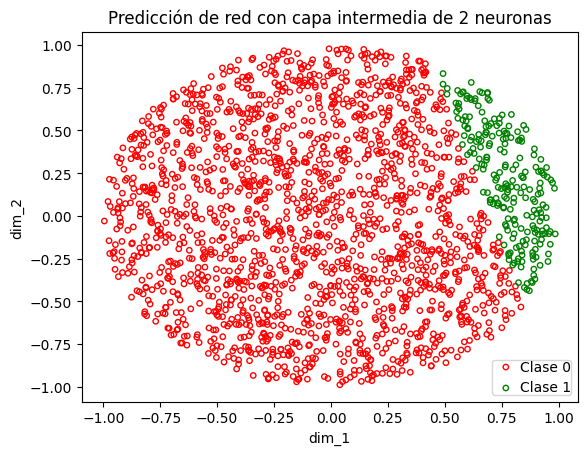

C:\Users\Certi\AppData\Local\Temp\ipykernel_24096\2214307645.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Certi\AppData\Local\Temp\ipykernel_24096\2214307645.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


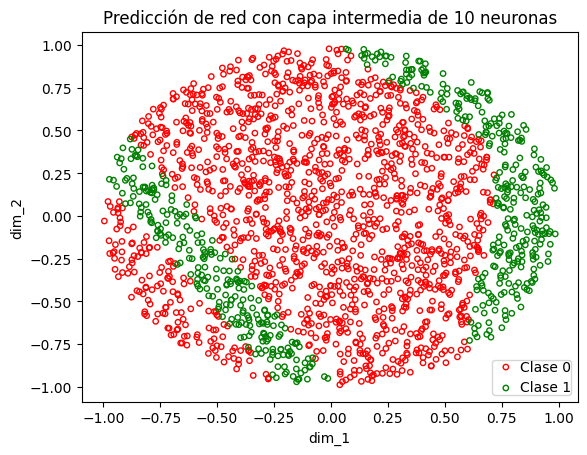

C:\Users\Certi\AppData\Local\Temp\ipykernel_24096\2214307645.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Certi\AppData\Local\Temp\ipykernel_24096\2214307645.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


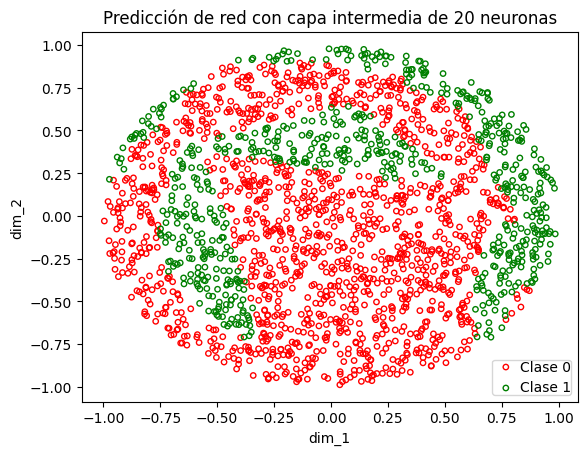

C:\Users\Certi\AppData\Local\Temp\ipykernel_24096\2214307645.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(
C:\Users\Certi\AppData\Local\Temp\ipykernel_24096\2214307645.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


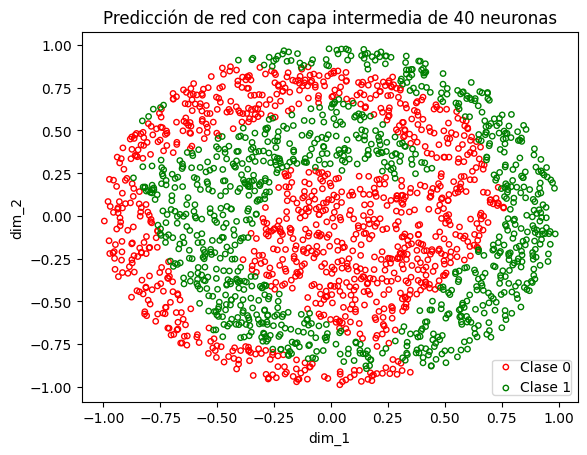

In [21]:
for k, v in redes.items():
  prediction = v.predict(X_test)
  idx = np.where(prediction == 0)
  plt.scatter(
      X_test[idx, 0],
      X_test[idx, 1],
      facecolors='none',
      edgecolors='r',
      label="Clase 0",
      cmap=plt.cm.RdYlBu,
      s=15,
  )

  idx = np.where(prediction == 1)
  plt.scatter(
      X_test[idx, 0],
      X_test[idx, 1],
      facecolors='none',
      edgecolors='g',
      label="Clase 1",
      cmap=plt.cm.RdYlBu,
      s=15,
  )

  plt.xlabel(feature_names[0])
  plt.ylabel(feature_names[1])
  plt.legend(loc="lower right", borderpad=0, handletextpad=0)
  plt.title(f'Predicción de red con capa intermedia de {k} neuronas')
  plt.show()

## Análisis

# Ejercicio 2

## Entrenamiento

In [48]:
X_data_aux, y_data_aux = cargar_csv("./data/dos_elipses.data", 2)
X_test, y_test = cargar_csv("./data/dos_elipses.test", 2)

X_data, _, y_data, _ = train_test_split(X_data_aux, y_data_aux, test_size = 0.5)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.2)

In [41]:
#defino parámetros de la red
epocas_por_entrenamiento = 50     #numero de epocas que entrena cada vez
evaluaciones = 300
N2 = 6

momentums = [0, 0.5, 0.9]
learnings = [0.1, 0.01, 0.001]
trys = 10

In [42]:
redes_sum = {}
redes_avg = {}
best_redes = {}

for alfa in momentums:
    for lr in learnings:
        best_error = 1.0
        for i in range(trys):
            clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=lr,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

            best_red, error_train, error_val, error_test = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
            
            if (alfa, lr) not in redes_sum:
                redes_sum[(alfa, lr)] = 0

            P_test = best_red.predict(X_test)
            test_error = zero_one_loss(y_test, P_test)
            redes_sum[(alfa, lr)] += test_error

            if test_error < best_error:
                best_error = test_error
                best_redes[(alfa, lr)] = {'best_error': best_error, 'best_red': best_red, 'error_train': error_train, 'error_val': error_val, 'error_test': error_test}
                
        redes_avg[(alfa, lr)] = redes_sum[(alfa, lr)] / trys

c:\Users\Certi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Certi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Certi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Certi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimiza

## Gráficos

In [46]:
data = {'Momentum': [], 'Learning rate': [], 'Error promedio': [], 'Error mínimo': []}

lowest_avg = 1.0
best_red = None
best_red_alfa = None
best_red_lr = None

for lr in learnings:
    for alfa in momentums:
        data['Momentum'].append(alfa)
        data['Learning rate'].append(lr)
        data['Error promedio'].append(redes_avg[(alfa, lr)])
        data['Error mínimo'].append(best_redes[(alfa, lr)]['best_error'])
        if redes_avg[(alfa, lr)] < lowest_avg:
            lowest_avg = redes_avg[(alfa, lr)]
            best_red = best_redes[(alfa, lr)]
            best_red_alfa = alfa
            best_red_lr = lr

df = pd.DataFrame(data)
print(df)

   Momentum  Learning rate  Error promedio  Error mínimo
0       0.0          0.100         0.13595        0.0165
1       0.5          0.100         0.14620        0.0180
2       0.9          0.100         0.09800        0.0310
3       0.0          0.010         0.24350        0.2435
4       0.5          0.010         0.23840        0.1925
5       0.9          0.010         0.14645        0.0220
6       0.0          0.001         0.24350        0.2435
7       0.5          0.001         0.24350        0.2435
8       0.9          0.001         0.24350        0.2435


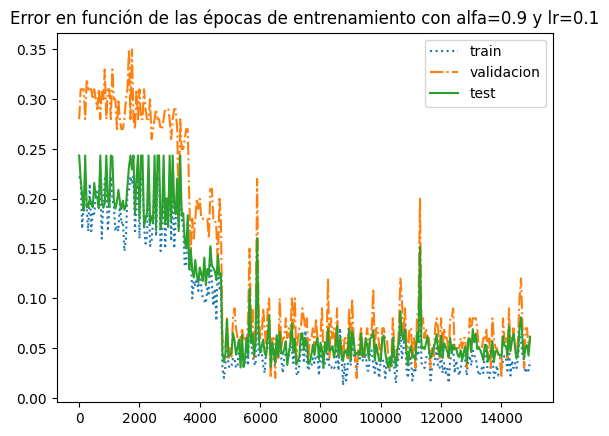

In [47]:
rango = np.array(range(evaluaciones)) * epocas_por_entrenamiento
plt.figure(figsize=(20, 7))
plt.plot(rango, best_red['error_train'], label="train", linestyle=":")
plt.plot(rango, best_red['error_val'], label="validacion", linestyle="-.")
plt.plot(rango, best_red['error_test'], label="test", linestyle="-")
plt.title(f'Error en función de las épocas de entrenamiento con alfa={best_red_alfa} y lr={best_red_lr}')
plt.legend()
plt.show()

## Análisis

# Ejercicio 3

## Carga de datos

In [18]:
X_data, y_data = cargar_csv("./data/ikeda.data", 5, delim_whitespace=True)
X_test_aux, y_test_aux = cargar_csv("./data/ikeda.test", 5, delim_whitespace=True)

X_test, _, y_test, _ = train_test_split(X_test_aux, y_test_aux, test_size = 0.58333333)

#defino parámetros de la red
epocas_por_entrenamiento=50     #numero de epocas que entrena cada vez
eta=0.01                         #learning rate
alfa=0.9                        #momentum
evaluaciones = 400
N2 = 30

redes = {}

C:\Users\Certi\AppData\Local\Temp\ipykernel_28332\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\Certi\AppData\Local\Temp\ipykernel_28332\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)


### Relación 95%-5%

In [19]:
test_size = 0.05
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = test_size)

regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(regr, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[test_size] = {'best_red': best_red, 'error_train': error_train, 'error_val': error_val, 'error_test': error_test}

### Relación 75%-25%

In [20]:
test_size = 0.25
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = test_size)

regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(regr, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[test_size] = {'best_red': best_red, 'error_train': error_train, 'error_val': error_val, 'error_test': error_test}

### 50%-50%

In [21]:
test_size = 0.5
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = test_size)

regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

best_red, error_train, error_val, error_test = entrenar_red(regr, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)
redes[test_size] = {'best_red': best_red, 'error_train': error_train, 'error_val': error_val, 'error_test': error_test}

## Gráficas

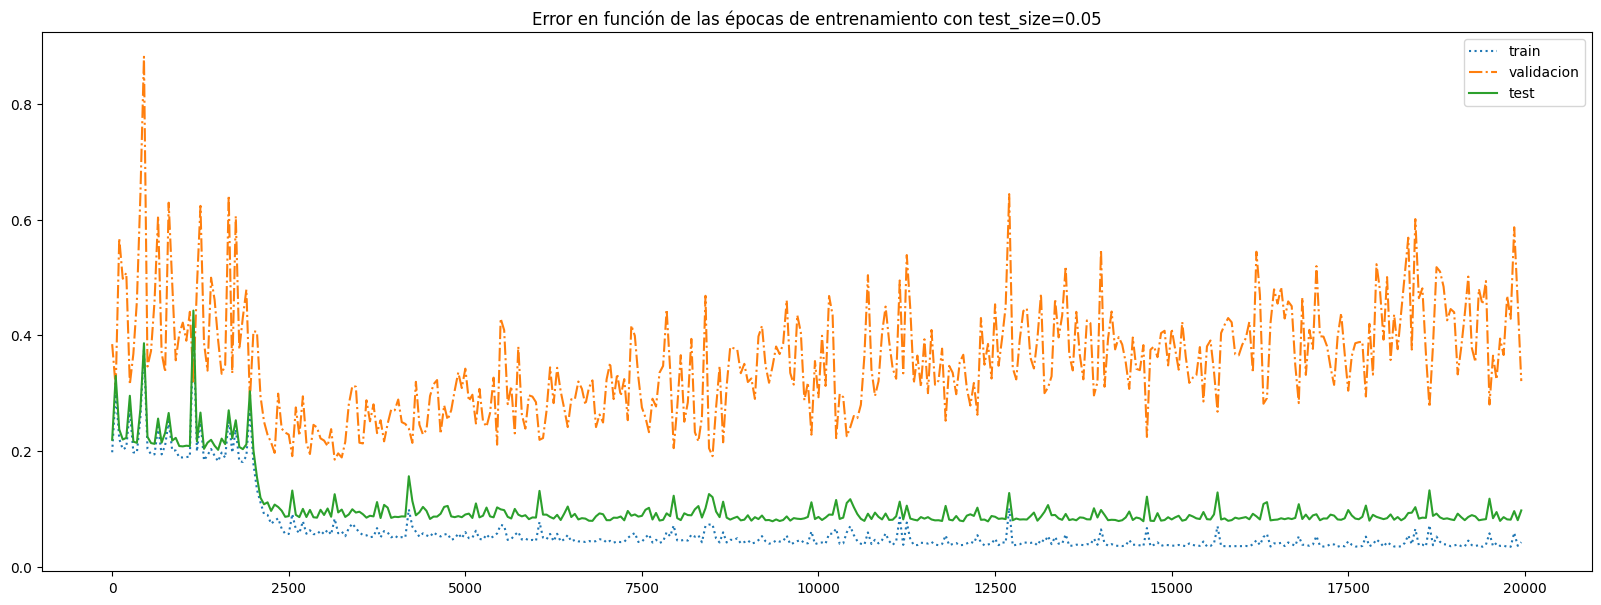

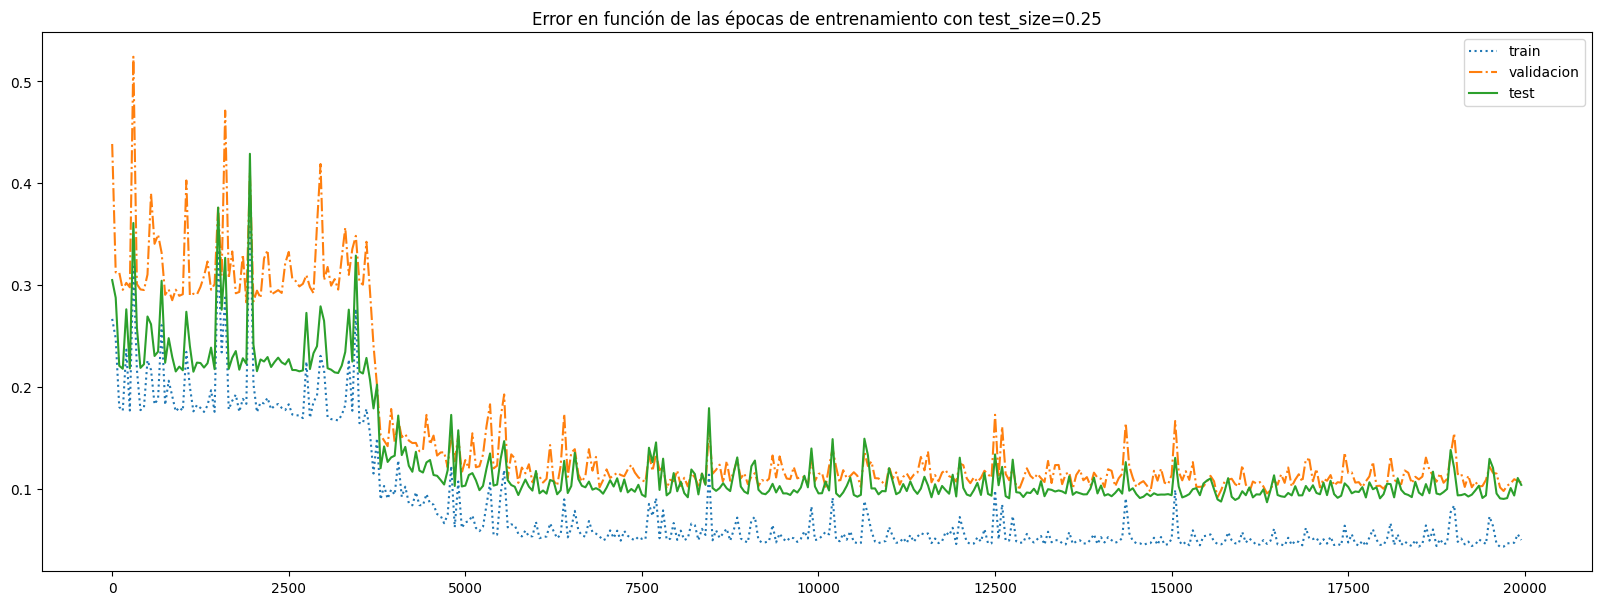

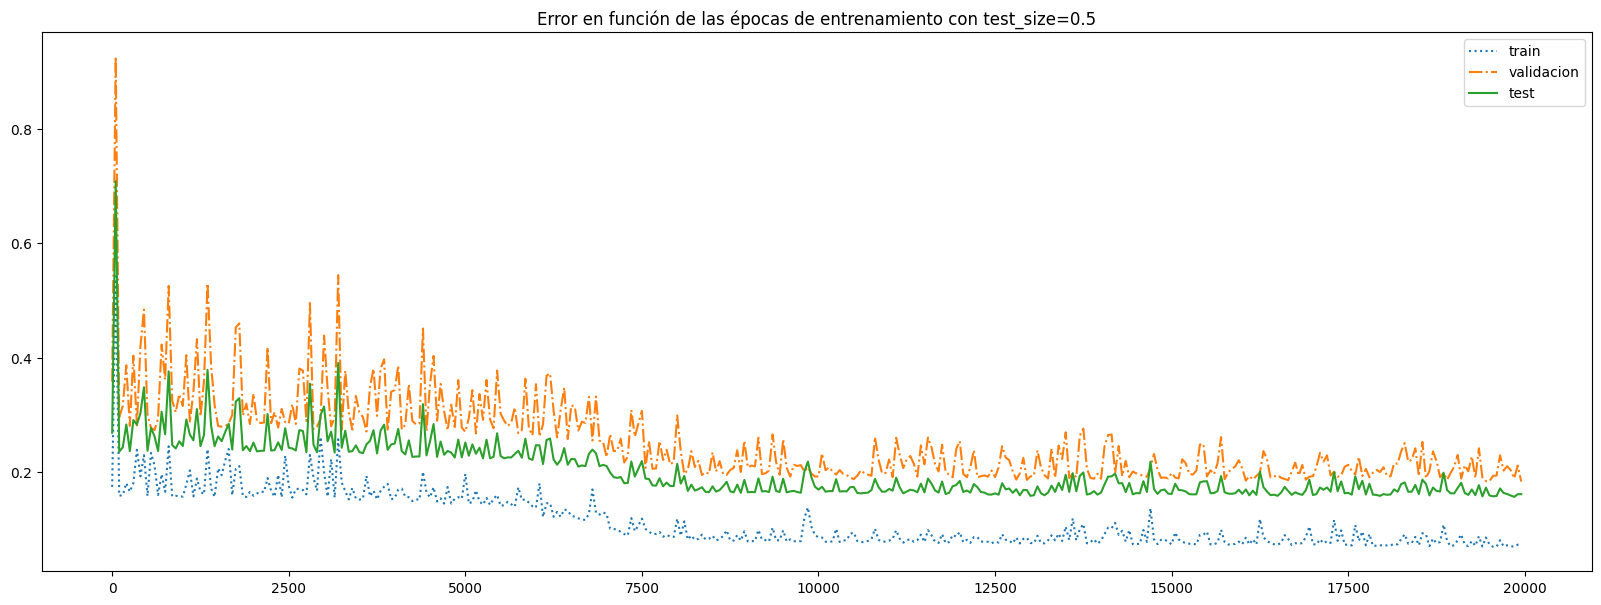

In [30]:
for k, v in redes.items():
    rango = np.array(range(evaluaciones)) * epocas_por_entrenamiento
    plt.figure(figsize=(20, 7))
    plt.plot(rango, v['error_train'], label="train", linestyle=":")
    plt.plot(rango, v['error_val'], label="validacion", linestyle="-.")
    plt.plot(rango, v['error_test'], label="test", linestyle="-")
    plt.title(f'Error en función de las épocas de entrenamiento con test_size={k}')
    plt.legend()
    plt.show()

## Análisis

# Ejercicio 4

## Carga de datos

In [35]:
X_train, y_train = cargar_csv("./data/ssp.data", 12)
X_test, y_test = cargar_csv("./data/ssp.test", 12)

#defino parámetros de la red
epocas_por_entrenamiento=20     #numero de epocas que entrena cada vez
eta=0.05                         #learning rate
alfa=0.3                        #momentum
evaluaciones = 4000
N2 = 6

gamma_values = [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]

redes = {}

C:\Users\Certi\AppData\Local\Temp\ipykernel_4680\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)
C:\Users\Certi\AppData\Local\Temp\ipykernel_4680\1536466213.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(path, delim_whitespace=delim_whitespace, header=None)



## Entrenamiento

In [36]:
for gamma in gamma_values:
    regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, weight_sum = entrenar_red_weight_decay(regr, evaluaciones, X_train, y_train, X_test, y_test)
    redes[gamma] = {'best_red': best_red, 'error_train': error_train, 'error_test': error_test, 'weight_sum': weight_sum}

c:\Users\Certi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Certi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Certi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Certi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimiza

## Gráficos

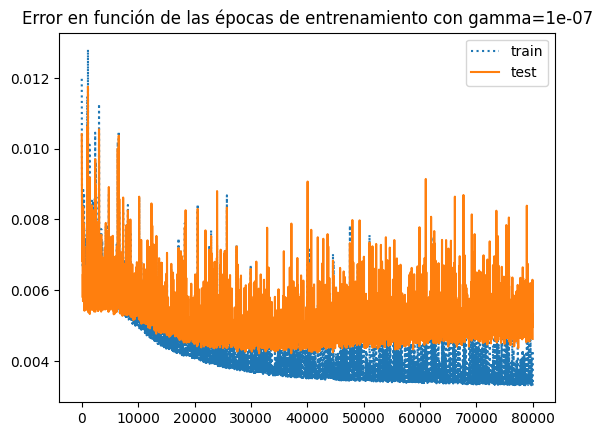

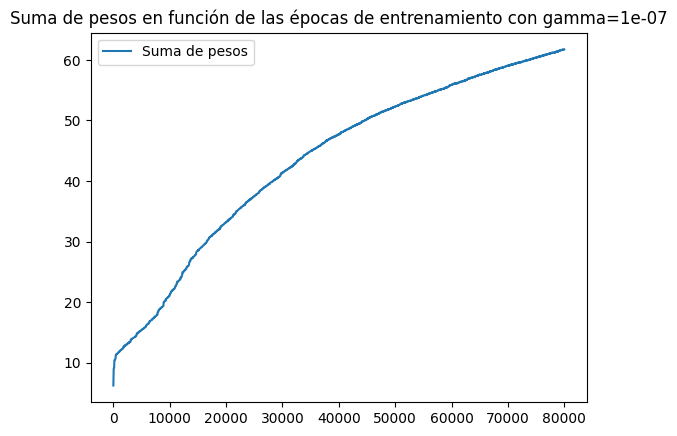

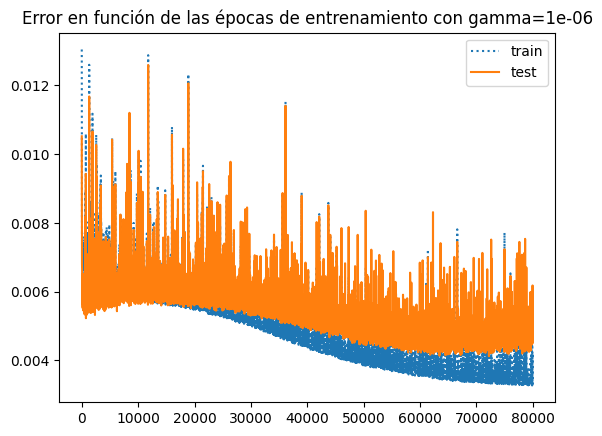

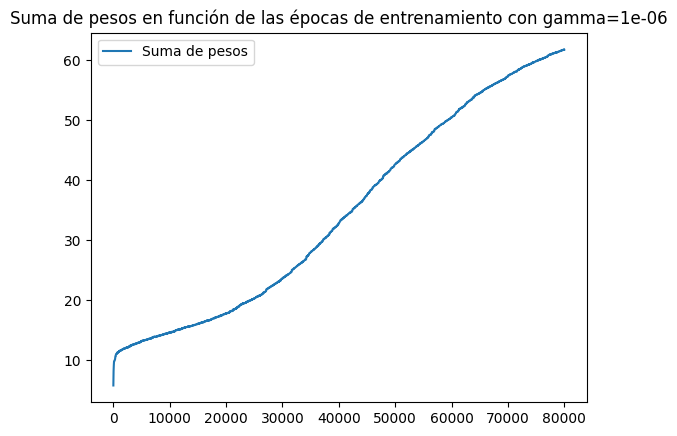

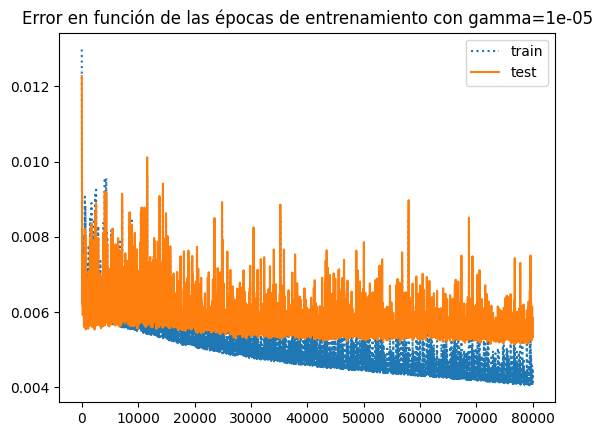

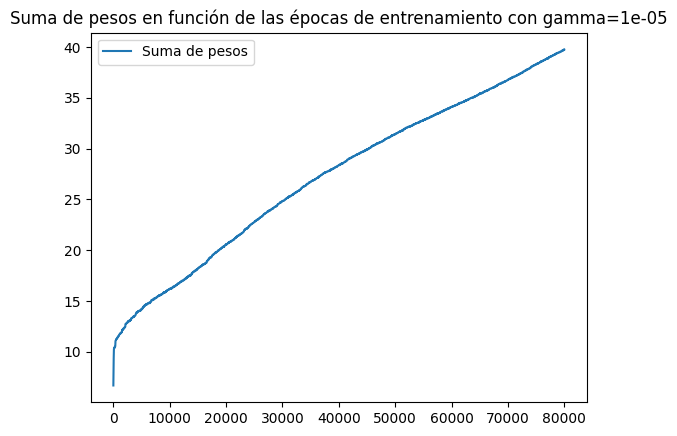

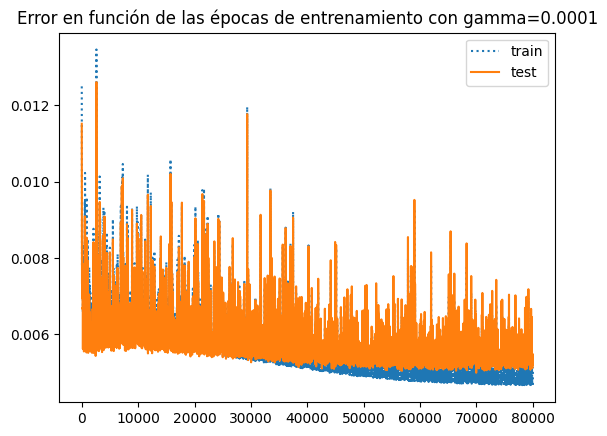

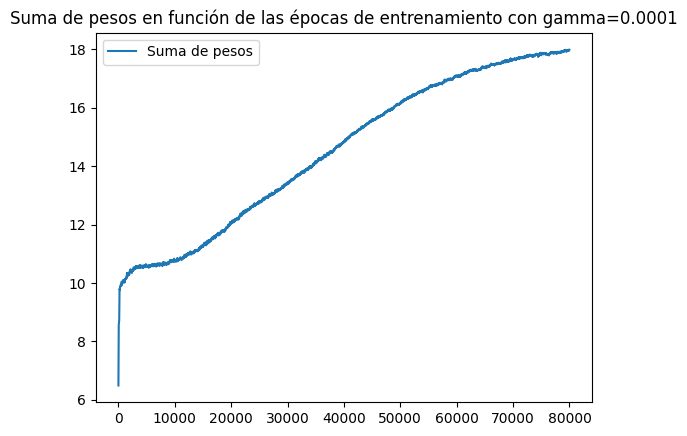

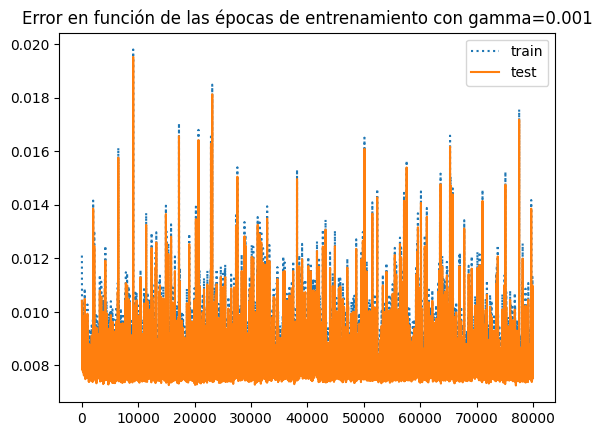

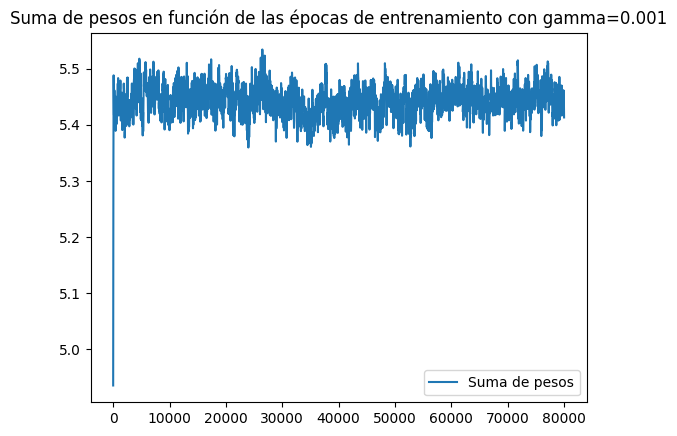

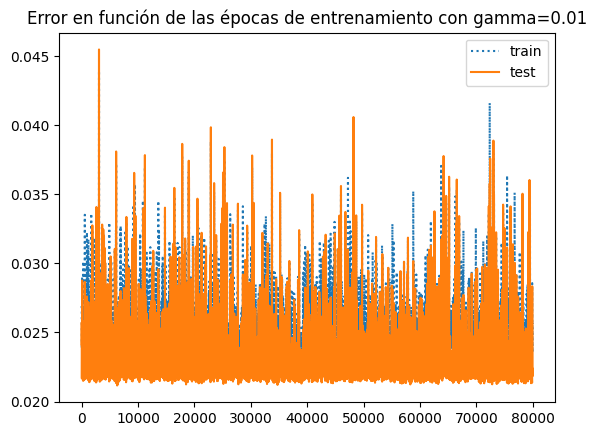

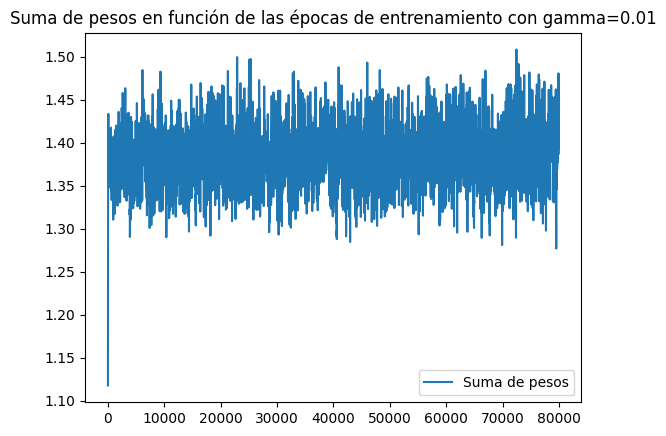

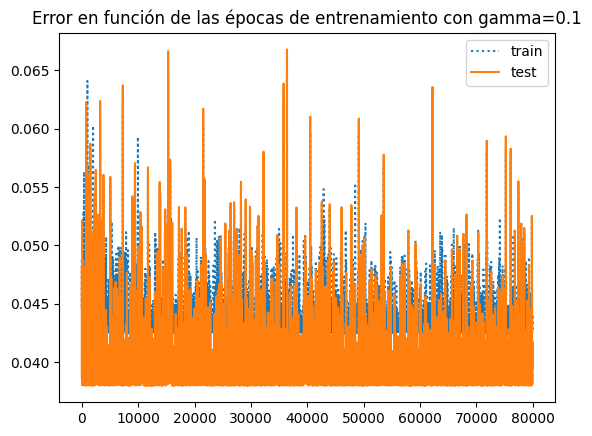

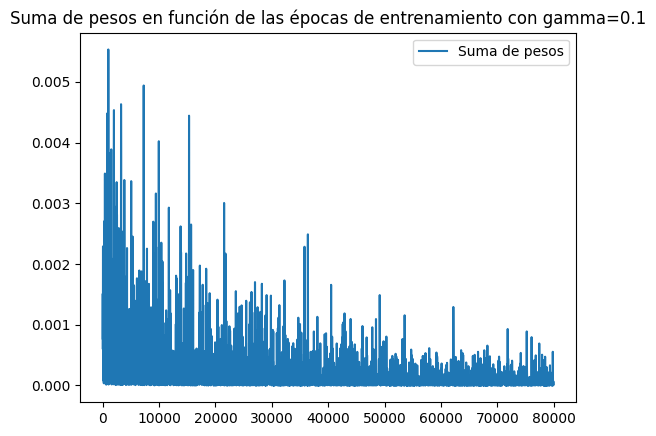

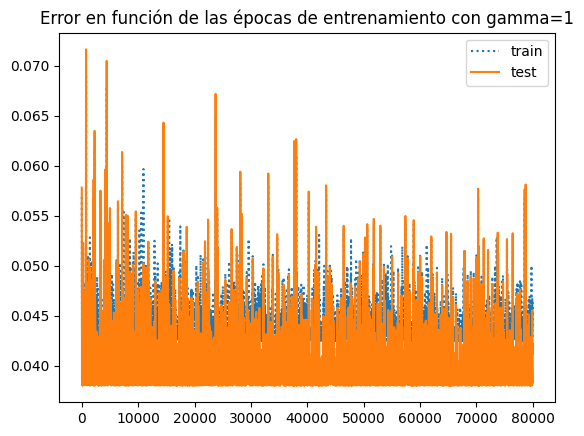

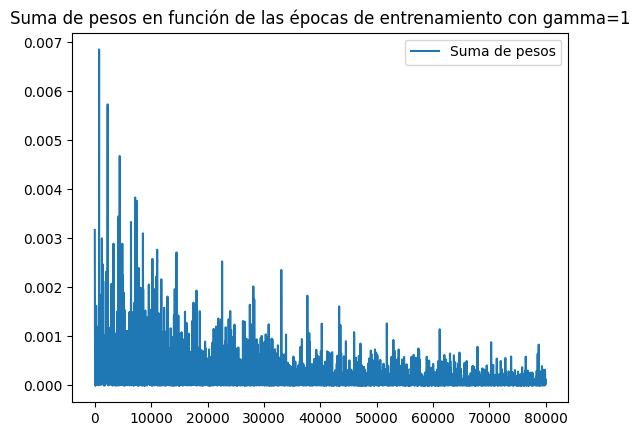

In [37]:
for k, v in redes.items():
    rango = np.array(range(evaluaciones)) * epocas_por_entrenamiento
    plt.figure(figsize=(20, 7))
    plt.plot(rango, v['error_train'], label="train", linestyle=":")
    plt.plot(rango, v['error_test'], label="test", linestyle="-")
    plt.title(f'Error en función de las épocas de entrenamiento con gamma={k}')
    plt.legend()
    plt.show()

    plt.plot(rango, v['weight_sum'], label="Suma de pesos")
    plt.title(f'Suma de pesos en función de las épocas de entrenamiento con gamma={k}')
    plt.legend()
    plt.show()

## Análisis

# Ejercicio 5

## Funciones de generación

In [5]:
def covM(d, C):
  return np.identity(d)*([(C*np.sqrt(d))**2]*d)

def diagonales(n, d, C):
  n0 = int(n/2)
  #Clase0
  c0 = [np.append(x, 0) for x in np.random.multivariate_normal([-1]*d, covM(d, C), n0)]
  #Clase1
  c1 = [np.append(x, 1) for x in np.random.multivariate_normal([1]*d, covM(d, C), n-n0)]

  flist = c0 + c1
  # Crear DataFrame
  df = pd.DataFrame(flist, columns=[f'dim_{i}' for i in range(d)] + ['class'])
  return df

def covM2(d, C):
  return np.identity(d)*([C**2]*d)

def paralelas(n, d, C):
  n0 = int(n/2)
  #Clase0
  c0 = [np.append(x, 0) for x in np.random.multivariate_normal([-1] + [0]*(d-1), covM2(d, C), n0)]
  #Clase1
  c1 = [np.append(x, 1) for x in np.random.multivariate_normal([1] + [0]*(d-1), covM2(d, C), n-n0)]

  flist = c0 + c1
  # Crear DataFrame
  df = pd.DataFrame(flist, columns=[f'dim_{i}' for i in range(d)] + ['class'])
  return df

## Valores generales

In [17]:
C = 0.78
n_training = 250
n_testing = 10000
d_values = [2, 4, 8, 16, 32]
# count_for_avg = 20
count_for_avg = 1

## Árboles

### Diagonales

In [18]:
errors_diagonales_trees = {}

for d in d_values:
  errors_list = []

  df_test = diagonales(n_testing, d, C)
  test_target = df_test["class"].to_numpy()
  test_data = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    df_train = diagonales(n_training, d, C)
    train_target = df_train["class"].to_numpy()
    train_data = df_train.drop(columns=["class"]).to_numpy()

    t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    t.fit(train_data, train_target)

    predict_test = t.predict(test_data)
    accuracy_test = accuracy_score(test_target, predict_test)

    predict_train = t.predict(train_data)
    accuracy_train = accuracy_score(train_target, predict_train)

    errors_list.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})

  errors_diagonales_trees[d] = errors_list

In [19]:
errors_test_diagonales_tree_avg = []
errors_train_diagonales_tree_avg = []
for k, l in errors_diagonales_trees.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_diagonales_tree_avg.append(sum_test/count_for_avg)
  errors_train_diagonales_tree_avg.append(sum_train/count_for_avg)

### Paralelas

In [20]:
errors_paralelas_tree = {}

for d in d_values:
  errors_list = []

  df_test = paralelas(n_testing, d, C)
  test_target = df_test["class"].to_numpy()
  test_data = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    df_train = paralelas(n_training, d, C)
    train_target = df_train["class"].to_numpy()
    train_data = df_train.drop(columns=["class"]).to_numpy()

    t = DecisionTreeClassifier(criterion="entropy",min_impurity_decrease=0.002,random_state=0,min_samples_leaf=5)
    t.fit(train_data, train_target)

    predict_test = t.predict(test_data)
    accuracy_test = accuracy_score(test_target, predict_test)

    predict_train = t.predict(train_data)
    accuracy_train = accuracy_score(train_target, predict_train)

    errors_list.append({'error_test': 1-accuracy_test, 'error_train': 1-accuracy_train})
  errors_paralelas_tree[d] = errors_list

In [21]:
errors_test_paralelas_tree_avg = []
errors_train_paralelas_tree_avg = []
for k, l in errors_paralelas_tree.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_paralelas_tree_avg.append(sum_test/count_for_avg)
  errors_train_paralelas_tree_avg.append(sum_train/count_for_avg)

## Redes

In [58]:
#defino parámetros de la red
epocas_por_entrenamiento=50     #numero de epocas que entrena cada vez
eta=0.1                         #learning rate
alfa=0.9                        #momentum
evaluaciones = 400
gamma = 0.0001
N2 = 6

### Diagonales

### Entrenamiento con validación

In [28]:
errors_diagonales_redes = {}

for d in d_values:
  errors_list = []

  df_test = diagonales(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Diagonales, d={d}, iteración={i}")
    df_train = diagonales(n_training, d, C)
    y_data = df_train["class"].to_numpy()
    X_data = df_train.drop(columns=["class"]).to_numpy()

    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.25)

    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, _, _, _ = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)

    p_test = best_red.predict(X_test)
    error_test = zero_one_loss(y_test, p_test)

    p_train = best_red.predict(X_train)
    error_train = zero_one_loss(y_train, p_train)

    errors_list.append({'error_test': error_test, 'error_train': error_train})

  errors_diagonales_redes[d] = errors_list

Diagonales, d=2, iteración=0
Diagonales, d=4, iteración=0
Diagonales, d=8, iteración=0
Diagonales, d=16, iteración=0
Diagonales, d=32, iteración=0


In [56]:
errors_test_diagonales_red_avg = []
errors_train_diagonales_red_avg = []
for k, l in errors_diagonales_redes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_diagonales_red_avg.append(sum_test/count_for_avg)
  errors_train_diagonales_red_avg.append(sum_train/count_for_avg)

print(errors_test_diagonales_red_avg)
print(errors_train_diagonales_red_avg)

[0.12170000000000003, 0.1512, 0.13529999999999998, 0.16159999999999997, 0.14480000000000004]
[0.10399999999999998, 0.08799999999999997, 0.052000000000000046, 0.10399999999999998, 0.08399999999999996]


### Entrenamiento con weight-decay

In [54]:
errors_diagonales_redes = {}

for d in d_values:
  errors_list = []

  df_test = diagonales(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Diagonales, d={d}, iteración={i}")
    df_train = diagonales(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, _ = entrenar_red_weight_decay(clasif, evaluaciones, X_train, y_train, X_test, y_test)

    errors_list.append({'error_test': error_test[-1], 'error_train': error_train[-1]})

  errors_diagonales_redes[d] = errors_list

Diagonales, d=2, iteración=0
Diagonales, d=4, iteración=0
Diagonales, d=8, iteración=0
Diagonales, d=16, iteración=0
Diagonales, d=32, iteración=0


In [49]:
errors_test_diagonales_red_avg = []
errors_train_diagonales_red_avg = []
for k, l in errors_diagonales_redes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_diagonales_red_avg.append(sum_test/count_for_avg)
  errors_train_diagonales_red_avg.append(sum_train/count_for_avg)

print(errors_test_diagonales_red_avg)
print(errors_train_diagonales_red_avg)

[0.10189999999999999, 0.11539999999999995, 0.24, 0.17120000000000002, 0.1511]
[0.11599999999999999, 0.06799999999999995, 0.21599999999999997, 0.11599999999999999, 0.10799999999999998]


### Paralelas

### Entrenamiento con conjunto de validación

In [40]:
errors_paralelas_redes = {}

for d in d_values:
  errors_list = []

  df_test = paralelas(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Paralelas, d={d}, iteración={i}")
    df_train = paralelas(n_training, d, C)
    y_data = df_train["class"].to_numpy()
    X_data = df_train.drop(columns=["class"]).to_numpy()

    X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size = 0.25)

    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=0.0, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, _, _, _ = entrenar_red(clasif, evaluaciones, X_train, y_train, X_val, y_val, X_test, y_test)

    p_test = best_red.predict(X_test)
    error_br_test = zero_one_loss(y_test, p_test)

    p_train = best_red.predict(X_train)
    error_br_train = zero_one_loss(y_train, p_train)

    errors_list.append({'error_test': error_br_test, 'error_train': error_br_train})

  errors_paralelas_redes[d] = errors_list

Paralelas, d=2, iteración=0
Paralelas, d=4, iteración=0
Paralelas, d=8, iteración=0
Paralelas, d=16, iteración=0
Paralelas, d=32, iteración=0


In [41]:
errors_test_paralelas_red_avg = []
errors_train_paralelas_red_avg = []
for k, l in errors_paralelas_redes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_paralelas_red_avg.append(sum_test/count_for_avg)
  errors_train_paralelas_red_avg.append(sum_train/count_for_avg)

print(errors_test_paralelas_red_avg)
print(errors_train_paralelas_red_avg)

[0.119, 0.14180000000000004, 0.10950000000000004, 0.13360000000000005, 0.12990000000000002]
[0.11229946524064172, 0.11764705882352944, 0.010695187165775444, 0.005347593582887722, 0.0]


### Entrenamiento con weight-decay

In [55]:
errors_paralelas_redes = {}

for d in d_values:
  errors_list = []

  df_test = paralelas(n_testing, d, C)
  y_test = df_test["class"].to_numpy()
  X_test = df_test.drop(columns=["class"]).to_numpy()

  for i in range(count_for_avg):
    print(f"Paralelas, d={d}, iteración={i}")
    df_train = paralelas(n_training, d, C)
    y_train = df_train["class"].to_numpy()
    X_train = df_train.drop(columns=["class"]).to_numpy()

    clasif = MLPClassifier(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)

    best_red, error_train, error_test, _ = entrenar_red_weight_decay(clasif, evaluaciones, X_train, y_train, X_test, y_test)

    errors_list.append({'error_test': error_test[-1], 'error_train': error_train[-1]})

  errors_paralelas_redes[d] = errors_list

Paralelas, d=2, iteración=0
Paralelas, d=4, iteración=0
Paralelas, d=8, iteración=0
Paralelas, d=16, iteración=0
Paralelas, d=32, iteración=0


In [57]:
errors_test_paralelas_red_avg = []
errors_train_paralelas_red_avg = []
for k, l in errors_paralelas_redes.items():
  sum_train = 0
  sum_test = 0
  for e in l:
    sum_train += e['error_train']
    sum_test += e['error_test']
  errors_test_paralelas_red_avg.append(sum_test/count_for_avg)
  errors_train_paralelas_red_avg.append(sum_train/count_for_avg)

print(errors_test_paralelas_red_avg)
print(errors_train_paralelas_red_avg)

[0.1078, 0.14, 0.14359999999999995, 0.14559999999999995, 0.16369999999999996]
[0.08399999999999996, 0.06000000000000005, 0.01200000000000001, 0.01200000000000001, 0.0]


## Gráficas

In [52]:
print("Test diagonales\n")
print(errors_test_diagonales_tree_avg)
print(errors_test_diagonales_red_avg)

print("Test paralelas\n")
print(errors_test_paralelas_tree_avg)
print(errors_test_paralelas_red_avg)

print("Train diagonales\n")
print(errors_train_diagonales_tree_avg)
print(errors_train_diagonales_red_avg)

print("Train paralelas\n")
print(errors_train_paralelas_tree_avg)
print(errors_train_paralelas_red_avg)

Test diagonales

[0.12760000000000005, 0.19730000000000003, 0.22829999999999995, 0.2996, 0.3548]
[0.10189999999999999, 0.11539999999999995, 0.24, 0.17120000000000002, 0.1511]
Test paralelas

[0.133, 0.12019999999999997, 0.16700000000000004, 0.11499999999999999, 0.134]
[0.11260000000000003, 0.127, 0.12860000000000005, 0.13749999999999996, 0.15049999999999997]
Train diagonales

[0.06000000000000005, 0.06399999999999995, 0.08399999999999996, 0.06399999999999995, 0.07599999999999996]
[0.11599999999999999, 0.06799999999999995, 0.21599999999999997, 0.11599999999999999, 0.10799999999999998]
Train paralelas

[0.08799999999999997, 0.03600000000000003, 0.06000000000000005, 0.04400000000000004, 0.04800000000000004]
[0.06000000000000005, 0.10799999999999998, 0.028000000000000025, 0.020000000000000018, 0.0040000000000000036]
